# Introduction


Data are pulled in as large files for ingest. These are external to the
repo folder so as not to bog it down (as repo size is constrained).
From this point there is an *ingest* process and a second process 
described below under the heading **Profiles**. 


To focus on *ingest* for a moment: The idea is to streamline the source
datasets by reducing clutter and cutting out a time window, say one month.
This notebook will start by considering a two year time range from 
1-JAN-2021 through 31-DEC-2022. From there we will focus on shorter
sub-ranges, typically a month in duration or less.



### Inbound data structure



There are two levels of source data time resolution: 1-minute average sampling
and full resolution sampling; which amounts to about 1 sample per second. 
The 1-minute-per-sample data will be smoother via 
averaging with the tradeoff of coarser depth resolution.


Again: Inbound data from OOI is kept outside this repo: In its own `/data/rca` 
folder. This inbound data folder structure is as follows:



```
$HOME/../data/rca/
                  OregonSlopeBase/
                                  platform/                (pc01a)
                                  profiler/                (sf01a)
                                           par/    
                                           do/
                                           vel/
                                           ctd/
                                           fluor/
                                           nitrate/
                                           pco2/
                                           ph/
                                           spkir/
                                           fullres_ctd/ etcetera
                  OregonOffshore/
                                  platform/                (pc01b)
                                  profiler/                (sf01b)
                  AxialBase/ 
                                  platform/               (pc03a)
                                  profiler/               (sf03a)

```

Please note that 1-minute-sample data goes into folders with no prefix; and 
full resolution (1-second-sample) data folders have the `fullres_` prefix 
as in `fullres_ctd`.


There are two resources for shallow profiler data:


- [Ocean Observatories Initiative **Data Explorer**](https://dataexplorer.oceanobservatories.org/)
- [Interactive Oceans **Data Portal**](https://interactiveoceans.washington.edu) which is specific to the Regional Cabled Array




### Terms used


* Regional Cabled Array (RCA): A cabled observatory on the sea floor and in select locations rising up through the water column: off the coast of Oregon
* Site: A location in the RCA
* Platform: A mechanical structure -- static or mobile -- at a site
* Instrument: A device fastened to a platform that carries one or more sensors
* Sensor: A device that measures some aspect of the ocean like pH or temperature
* Stream: Data produced by a sensor as part of an instrument located on a platform at a site in the RCA
* Profiler 'Oregon Slope Base' SF01A????????? SFO3A????????????
* Profiler 'Axial Base' PN3A 
* Profiler 'Oregon Offshore' (shared with the OSU array)


#### Sensor dictionary with abbreviations

```
Short   Data                  Renamed       Instrument     Runs
-----   ----                  -------       ----------     -----------
A       Chlorophyll-A         chlora        fluorometer    continuous
B       backscatter           backscatter                  continuous
C       CDOM                  cdom                         continuous
E[]     Spectrophotometer     spec          spec           ? (83 channels)
G       pCO2                  pco2          pCO2           midnight/noon descent
H       pH                    ph            pH             midnight/noon descent
I[]     Spectral Irradiance 1 oa            spkir-oa       ? (7 channels)
J[]     Spectral Irradiance 2 ba            spkir-ba       ? (7 channels)
M       Nitrate 1             ?             nitrate        midnight/noon ascent
N       Nitrate 2             ?                            midnight/noon ascent
P       PAR                   par           PAR            continuous
Q       pressure              pressure      CTD            continuous
O       dissolved oxygen      doxygen                      continuous
S       salinity              salinity                     continuous
T       temperature           temp                         continuous
U       velocity east         veast         current        continuous:
V       velocity north        vnorth                           from platform
W       velocity up           vup                              looking up
```

### Data download


As noted above: [OOI](https://oceanobservatories.org) 
provides data access via the [Data Explorer](https://dataexplorer.oceanobservatories.org/).
An alternative resource particular to the *OOI cabled array* is the
[Cabled Array data server](https://interactiveoceans.washington.edu).
This site is oriented towards built-in data exploration and is very educator-friendly. 


#### Example download


- [Data access page in the Data Explorer](https://dataexplorer.oceanobservatories.org/#go-to-data-access)
- Access Array Data, Oregon Margin, Profiling Assets, All Instrument Types, All Parameters, Go
    - A very dense page with charts, tabs, multiple scroll bars and so forth
    - Exploration of the various tabs encouraged
        - **Data**, **Inventory**, **Downloads**, **Annotations**, **Deployments**
    - > **Downloads** tab
    - Full resolution data: 1 second per sample
        - Choose link '*full resolution downloads*'
        - Page of fluorometer datasets in deployment sequence: time ranges shown
        - Select Downloads > THREDDS Catalog > Dataset > page listing files
        - Deployment 8, FLORT for the triplet
        - Check the time range in the filename for best match to March 2021
        - Click to go to yet another page, this one for "ACCESS" and multiple choices
            - Select HTTPServer to download the NetCDF data file: 600+ MB
    - 1Min resolution: 1 minute per sample
        - Green **Download** button for various streams / sensors 
        - Three format options: ERDDAP (+ 3 sub-options), CSV and NetCDF
            - NetCDF URL gives a shareable download link
            - NetCDF **Download** button > 1Min downsampled data
                - These datasets extend over the full OOI program duration: 2014 to present
            - Data description text + chart symbol (left) produces a curtain plot


Full resolution data is sub-divided into consecutive time ranges called "deployments". 
The resulting NetCDF files have these distinctions compared to the 1Min data:


- Data is sampled at about one sample per second
- Sensors are combined in NetCDF files
    - For example a CTD file includes salinity, temperature, pressure, density and conductivity
- The data files are much larger on average
- The sample dimension is `obs` (observation number) rather than `row`
    - However the swap procedure is the same: Swap in `time`


#### Code


This notebook defers some functions to the module file `data.py`.

In [1]:
import os, sys, time, glob, warnings
from os.path import join as joindir
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

from data import *

warnings.filterwarnings('ignore')

def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


In [2]:
## Run this cell to reformat a data file and write it in its new form.
# Example output file: 'axb_nitrate_jan22_nitrate.nc' gives site, instrument, sensor and time range

# if not ReformatDataFile(False): print('ReformatDataFile() returned False')

#### Test dataset

On 10/16/23 the 1min datasets (repo-external /data folder) from OOI were processed for storage
and use in this repository. The file naming convention is 


**`<site>_<instrument>_<month>_<sensor>.nc`**.


Hence for the Oregon Slope Base profiler we have `osb_spkir_jan22_spkir.nc` using the OOI abbreviation
for spectral irradiance **`spkir`**. Note that the sensor and instrument are the same in this case.
In the case of the fluorometer and CTD the sensor is not the same as the instrument.


In this case the time range was constrained Jan 1 to Feb 1 2022. At the moment it is unclear how 
the velocity data is produced: From a sensor on the profiler or from a sensor on the platform?


The only data file containing streams from multiple sensors is the spectral irradiance (spkir) file.
This records 7 wavelength bands. While instruments ctd, fluor and vel have multiple
sensors these are split into separate data files.

In [3]:
jan22_data = [
'osb_ctd_jan22_pressure.nc',
'osb_ctd_jan22_temperature.nc',
'osb_ctd_jan22_density.nc',
'osb_ctd_jan22_salinity.nc',
'osb_ctd_jan22_conductivity.nc',
'osb_fluor_jan22_fdom.nc',
'osb_fluor_jan22_chlora.nc',
'osb_fluor_jan22_bb.nc',
'osb_spkir_jan22_spkir.nc',
'osb_nitrate_jan22_nitrate.nc',
'osb_pco2_jan22_pco2.nc',
'osb_do_jan22_do.nc',
'osb_par_jan22_par.nc',
'osb_ph_jan22_ph.nc',
'osb_vel_jan22_up.nc',
'osb_vel_jan22_east.nc',
'osb_vel_jan22_north.nc']

#### Data review


The above cell generates a set of about 17 time-bounded NetCDF measurement data files. 
To review these files and their *XArray Dataset data variable* names: Activate and run the
following code. The cell below captures these names into a list of lists.
    
```
data_prefix = '../data/'
for f in jan22_data:
    ds = xr.open_dataset(data_prefix + f)
    print(ds)
    r = input('enter to continue')
```

In [4]:
# The relative path to the data files from the Notebooks folder is up one level, then to the data folder
data_prefix = '../data/'

# The data variables corresponding to the jan22_data files defined above
jan22_data_vars = [
    ['pressure'],['temperature'],['density'], ['salinity'], ['conductivity'],
    ['fdom'], ['chlora'], ['bb'],
    ['412nm', '443nm', '490nm', '510nm', '555nm', '620nm', '683nm'],
    ['nitrate'],
    ['pco2'],
    ['do'],
    ['par'],
    ['ph'],
    ['up'], ['east'], ['north']]

## Profiles


The final task of this notebook is to produce a table of profile metadata. 


Profile timing is driven by the RCA engineering system, producing some variability in profile
timing. Also shallow profilers occasionally go out of service. Using profile time/depth data we
produce a table of timestamps corresponding to 3-part profile cycles: Ascent, Descent and Rest. 
This table is used in subsequent analysis to isolate individual profiles.


The following cell illustrates a typical day of profiling cycles.


- The time scale for January 10 is in UTM hours
- Nine profiles are run, two of which are noticeably longer in duration
- The two longer profiles at midnight and noon associate with nitrate, pCO2 and pH measurement
    - These have built-in pauses for equilibration during descent
- During the *rest* intervals the profiler is secured in an anchored platform
    - The platform has its own set of instruments

True

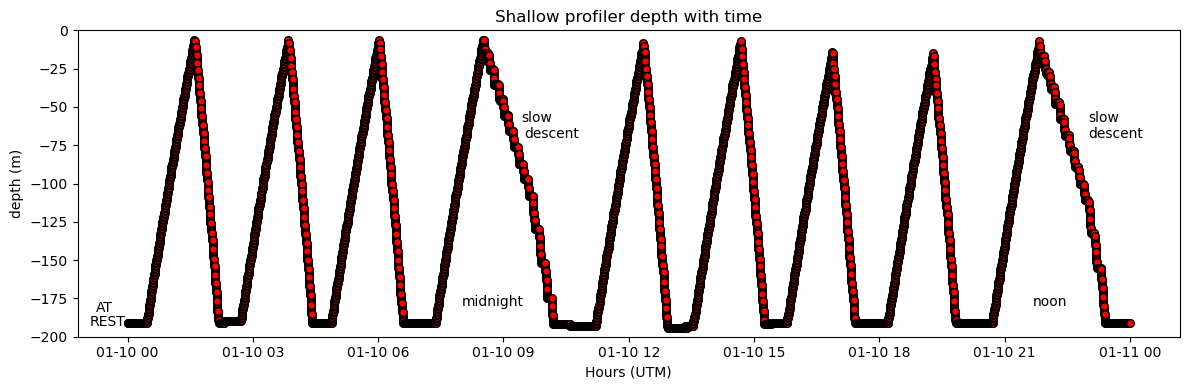

In [5]:
def ProfilerDepthChart(t0, t1, fnm, annotate=False):
    ds = xr.open_dataset(fnm).sel(time=slice(dt64(t0), dt64(t1)))
    fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)
    axs.plot(ds.time, ds.z, marker='.', ms=11., color='k', mfc='r', linewidth='.0001')
    axs.set(ylim = (-200., 0.), title='Shallow profiler depth with time', ylabel='depth (m)', xlabel='Hours (UTM)')
    if annotate:
        axs.text(dt64('2022-01-09 23:15'), -184, 'AT')
        axs.text(dt64('2022-01-09 23:05'), -193, 'REST')
        axs.text(dt64('2022-01-10 08'), -180, 'midnight')
        axs.text(dt64('2022-01-10 21:40'), -180, 'noon')
        axs.text(dt64('2022-01-10 09:25'), -60, 'slow')
        axs.text(dt64('2022-01-10 09:30'), -70, 'descent')
        axs.text(dt64('2022-01-10 23:00'), -60, 'slow')
        axs.text(dt64('2022-01-10 23:00'), -70, 'descent')
    return True

ProfilerDepthChart('2022-01-10', '2022-01-11', data_prefix + jan22_data[0], True)

-191.0 is initial depth
there are 279 ascent starts
there are 279 descent starts
there are 279 rest starts
no causal problems found
101


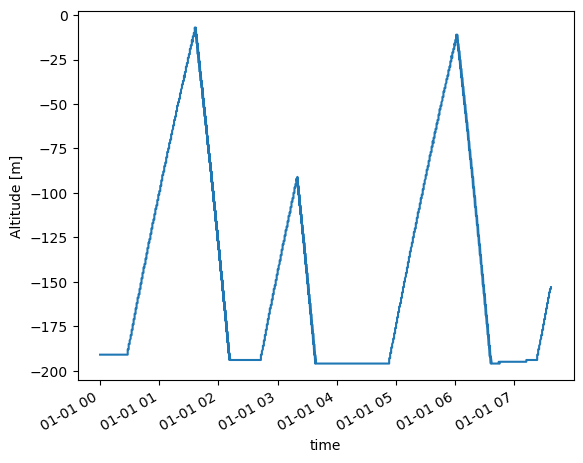

In [6]:
def ProfCrawler(z, t, verbose = False):
    """
    ProfileCrawler traverses pandas Series s of pressures/depths and matching pandas Series t of times.
    The code is adapted to 1Min per sample and z is increasing up / shallow. (See 'z_direction'.)
    The code returns a set of 6 lists: t0/t1 for ascent, descent and rest intervals
    """
    print(str(z[0]) + ' is initial depth')

    len_z = len(z)
    a0, d0, r0 = [], [], []               # lists for start times: ascents, descents, rests

    # In the following code we are checking index 'i': Is it an ascent start? A descent start? 
    #   A rest start? If so we add a triple (index, time, depth) to the corresponding list.
    #   The first possible i is set as m0; the last is len_z - m1 - 1. len_z is the number of
    #   values in the time series; and we cut off the ends to permit time window derivatives.
    # Note that z[m0] is m0 minutes ahead of z[0] since samples are assumed to be one per minute.
    #   Likewise z[len_z - m1 - 1] is m1 minutes behind z[len_z - 1].
    # The depth values z[] are taken to be negative down from 0 at the surfae.
    # Time-series derivatives are taken in terms of (later) - (earlier) in the normal sense.
    # Conditions for identifying an Ascent start:
    #   - Slope from past to present is less than a threshold (flat)
    #   - Slope from present to future is positive (rising)
    #   - The profiler is below some depth threshold (eliminates some false positives)
    # After a detection of an Ascent start the i index is bumped forward in time to try and
    #   avoid adjacent false positives.
    # 
    m0 = 8
    m1 = 8
    ascent_threshold0 = 0.2
    ascent_threshold1 = .5
    ascent_min_depth = -170.
    ascent_bump_i = 10        # 7 "works" but a bit bigger is maybe no harm
    descent_threshold0 = -0.2
    descent_threshold1 = -0.5
    descent_bump_i = 10
    rest_threshold0 = -0.5
    rest_threshold1 = 0.2
    rest_min_depth = -170.
    rest_bump_i = 10

    # This pushes the index forward after an a0 is detected to skip some false positives
    ascent_threshold0 = 0.2
    ascent_threshold1 = .5
    
    i = m0
    while i < len_z - m1:      # i is a candidate index for A/D/R starts
        
        # ascent
        slope0 = (z[i] - z[i-m0])/m0
        slope1 = (z[i+m1] - z[i])/m1
        
        # print(slope0, slope1)
        if slope0 <= ascent_threshold0 and slope1 >= ascent_threshold1:
            if z[i] <= ascent_min_depth:
                a0.append((i, t[i], z[i]))
                i += ascent_bump_i
                
        elif slope0 >= descent_threshold0 and slope1 <= descent_threshold1:        
            # (no depth condition) so on to the cases where this is considered a new descent:
            #   No descents found yet OR the most recent descent precedes the most recent ascent
            if (not len(d0)) or (len(a0) and len(d0) and d0[-1][0] < a0[-1][0]):
                d0.append((i, t[i], z[i]))
                i += descent_bump_i
                
        elif slope0 <= rest_threshold0 and abs(slope1) <= rest_threshold1:
            if z[i] <= rest_min_depth:
                if (not len(r0)) or (len(d0) and len(r0) and r0[-1][0] < d0[-1][0]):
                    r0.append((i, t[i], z[i]))
                    i += rest_bump_i

        i += 1

    if verbose: print("there are", len(a0), "ascent starts")
    if verbose: print("there are", len(d0), "descent starts")
    if verbose: print("there are", len(r0), "rest starts")
    
    # skipping: iterate until no positives: is r0 monotonic by index?
    #   (if not: throw out the offender and check again)
    
    a1 = d0.copy()             # ascent end = descent start
    d1 = r0.copy()             # descent end = rest start
    r1 = a0[1:].copy()         # rest end = next ascent start (cuts off end of year)
    
    # logic check on results
    causal_errors = [0]*3                 # list [0, 0, 0] tracks 3 types of possible error
    smallest = len(a0)
    if len(d0) < smallest: smallest = len(d0)
    if len(r0) < smallest: smallest = len(r0)
    for i in range(smallest):
        if a0[i][0] >= d0[i][0]: causal_errors[0] += 1    # ascent start later than descent start
        if d0[i][0] >= r0[i][0]: causal_errors[1] += 1    # descent start later than rest start
        if a1[i][0] >= d1[i][0]: causal_errors[2] += 1    # ascent end later than descent end (???)
        
    if causal_errors[0] or causal_errors[1] or causal_errors[2]:
        print('# times ascent start > descent start: ' + str(causal_errors[0]))
        print('# times descent start > rest start: ' + str(causal_errors[1]))
        print('# times ascent end > descent end: ' + str(causal_errors[2]))
    else: print('no causal problems found')
    
    # Returning lists of tuples: (index, time, depth)
    return a0, a1, d0, d1, r0, r1  

def ProfileGenerator(sourcefnm, s, z, verbose=True):
    """
    Generate a profile CSV file for a site and a time interval implicit in a depth/time NetCDF file 
    Example: result = ProfileWriter('source.nc', 'axb', 'z', True)
      sourcefnm is a NetCDF file containing pressure/depth and time
      s is a site label string
      y0, yN give an inclusive year range
    """
    ds = xr.open_dataset(sourcefnm)

    # if dim not 'time' return False
    
    t0 = ds['time'][0]
    t1 = ds['time'][-1]
    
    a0, a1, d0, d1, r0, r1 = ProfCrawler(ds[z].to_series(), ds['time'].to_series(), True)
    
    ds[z][0:1440].plot()
    print(len(ds['time'])//60//24)
    # return True
    return a0, a1, d0, d1, r0, r1

a0, a1, d0, d1, r0, r1 = ProfileGenerator('../data/osb_ctd_jan22_pressure.nc', 'osb', 'z', True)

In [7]:
ds = xr.open_dataset('../data/osb_ctd_jan22_pressure.nc')
ds

<xarray.Dataset>
Dimensions:   (time: 146283)
Coordinates:
  * time      (time) datetime64[ns] 2022-01-01 ... 2022-02-01
Data variables:
    pressure  (time) float64 ...
    z         (time) float64 ...

In [ ]:
ds['time'][0], ds['time'][-1]

In [ ]:
30.5*24*60*60

In [ ]:
31/2.6

In [23]:
ds = xr.open_dataset('../data/osb_ctd_jan22_pressure.nc')

ndup = 0
nbadpressure = 0

for i in range(1, 30):
    t0 = ds['time'][i-1]
    t1 = ds['time'][i]
    if t1 == t0: 
        ndup += 1
        if not ds['pressure'][i] == ds['pressure'][i-1]: 
            print(ds['pressure'][i], ds['pressure'][i-1])
            nbadpressure += 1

print('duplicates: ', str(ndup))
print('non-match pressures: ', str(nbadpressure))
print('backwards: ', str(nbackwards))

<xarray.DataArray 'pressure' ()>
array(191.646596)
Coordinates:
    time     datetime64[ns] 2022-01-01T00:28:00
Attributes: (12/13)
    _ChunkSizes:          512
    actual_range:         [  3.13469784 239.12638942]
    ancillary_variables:  sea_water_pressure_profiler_depth_enabled_qc_agg se...
    discrimant:           profiler_depth_enabled
    discriminant:         profiler_depth_enabled
    id:                   1019874
    ...                   ...
    long_name:            Sea Water Pressure
    platform:             station
    short_name:           sea_water_pressure
    standard_name:        sea_water_pressure
    standard_name_url:    http://mmisw.org/ont/cf/parameter/sea_water_pressure
    units:                decibars <xarray.DataArray 'pressure' ()>
array(192.523452)
Coordinates:
    time     datetime64[ns] 2022-01-01T00:28:00
Attributes: (12/13)
    _ChunkSizes:          512
    actual_range:         [  3.13469784 239.12638942]
    ancillary_variables:  sea_water_pressu

In [33]:
print(float(ds['pressure'][28]))
print(float(ds['pressure'][29]))
print(float(ds['pressure'][30].data))

192.5234520172
191.646596066
190.6351883806


In [36]:
ds = xr.open_dataset('../data/osb_ctd_jan22_pressure.nc')
print(ds)
da=ds['pressure']
print(type(da))
print(da)

<xarray.Dataset>
Dimensions:   (time: 146283)
Coordinates:
  * time      (time) datetime64[ns] 2022-01-01 ... 2022-02-01
Data variables:
    pressure  (time) float64 ...
    z         (time) float64 ...
<class 'xarray.core.dataarray.DataArray'>
<xarray.DataArray 'pressure' (time: 146283)>
[146283 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-01T00:01:00 ... 2022-02-01
Attributes: (12/13)
    _ChunkSizes:          512
    actual_range:         [  3.13469784 239.12638942]
    ancillary_variables:  sea_water_pressure_profiler_depth_enabled_qc_agg se...
    discrimant:           profiler_depth_enabled
    discriminant:         profiler_depth_enabled
    id:                   1019874
    ...                   ...
    long_name:            Sea Water Pressure
    platform:             station
    short_name:           sea_water_pressure
    standard_name:        sea_water_pressure
    standard_name_url:    http://mmisw.org/ont/cf/parameter/sea_w

In [35]:
da.pressure.plot()

AttributeError: 'DataArray' object has no attribute 'pressure'

In [37]:
_, keeper_index = np.unique(ds['time'], return_index=True)
ds=ds.isel(time=keeper_index)
ds

<xarray.Dataset>
Dimensions:   (time: 44638)
Coordinates:
  * time      (time) datetime64[ns] 2022-01-01 ... 2022-02-01
Data variables:
    pressure  (time) float64 ...
    z         (time) float64 ...

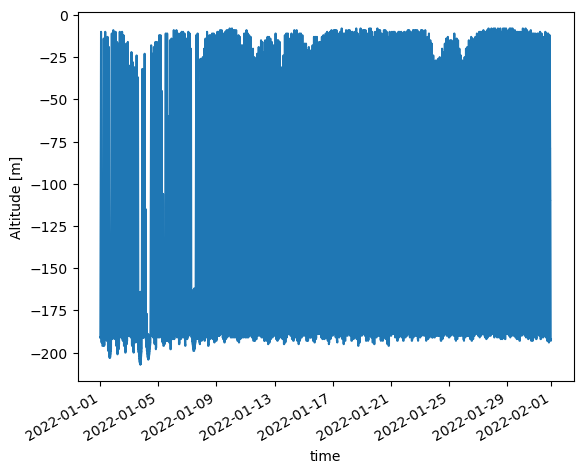

In [38]:
ds.z.plot()

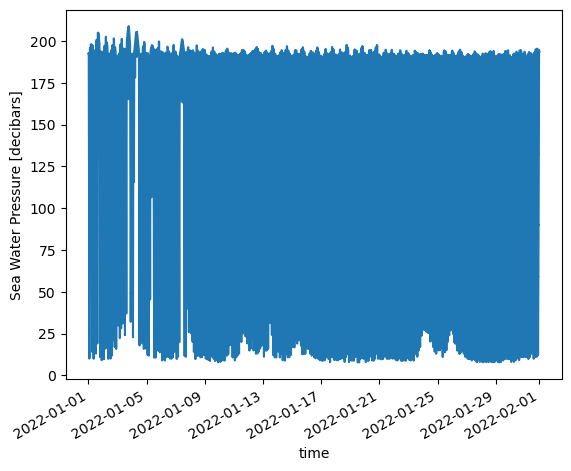

In [39]:
ds.pressure.plot()

In [ ]:


        print(len(a0), len(d0), len(r0), 'interval starts')
        print(len(a1), len(d1), len(r1), 'interval ends')


        if len(a0) < 10 or len(a1) < 10 or len(d0) < 10 or len(d1) < 10 or len(r0) < 10 or len(r1) < 10:
            print()
            print('No data: Abandoning this site + year:', site, yrstr)
            print()
        else:

            # we have intervals; do they match? Assume not always. Here is a checking function:
            # CompareShallowProfilerTimestamps(a0, a1, d0, d1, r0, r1)

            ascents, descents, rests = [], [], []
            day_td64                 = pd.to_timedelta(1, unit='D')
            ascent_limit             = pd.to_timedelta(2, unit='H')
            descent_limit            = pd.to_timedelta(2, unit='H')
            rest_limit               = pd.to_timedelta(2, unit='H')
            prior_ascent_start       = a0[0][1] - day_td64
            prior_descent_start      = d0[0][1] - day_td64
            prior_rest_start         = r0[0][1] - day_td64

            end_index = 0     # index into a1
            for i in range(len(a0)):
                all_done = False
                this_start_time = a0[i][1]
                if this_start_time > prior_ascent_start:
                    while a1[end_index][1] <= this_start_time: 
                        end_index += 1
                        if end_index >= len(a1):
                            all_done = True
                            break
                    if all_done: break
                    this_end_time = a1[end_index][1]
                    if this_end_time < this_start_time + ascent_limit:
                        prior_ascent_start = this_start_time
                        ascents.append([a0[i][0], this_start_time, a1[end_index][0], this_end_time])
                if all_done: break

            end_index = 0     # index into d1
            for i in range(len(d0)):
                all_done = False
                this_start_time = d0[i][1]
                if this_start_time > prior_descent_start:
                    while d1[end_index][1] <= this_start_time: 
                        end_index += 1
                        if end_index >= len(d1):
                            all_done = True
                            break
                    if all_done: break
                    this_end_time = d1[end_index][1]
                    if this_end_time < this_start_time + descent_limit:
                        prior_descent_start = this_start_time
                        descents.append([d0[i][0], this_start_time, d1[end_index][0], this_end_time])
                if all_done: break


            end_index = 0     # index into r1
            for i in range(len(r0)):
                all_done = False
                this_start_time = r0[i][1]
                if this_start_time > prior_rest_start:
                    while r1[end_index][1] <= this_start_time: 
                        end_index += 1
                        if end_index >= len(r1):
                            all_done = True
                            break
                    if all_done: break
                    this_end_time = r1[end_index][1]
                    if this_end_time < this_start_time + rest_limit:
                        prior_rest_start = this_start_time
                        rests.append([r0[i][0], this_start_time, r1[end_index][0], this_end_time])
                if all_done: break

            print("found", len(ascents), 'good ascents')
            print("found", len(descents), 'good descents')
            print("found", len(rests), 'good rests')

            # profiles[] will be a list of clean ascend/descend/rest sequences, 12 numbers per sequence
            #   ascend start:  index, timestamp        
            #   ascend end:    index, timestamp      The 'index' refers to the source dataset, typically at "1Min"
            #   descend start: index, timestamp      sampling rate. Note that ascend end = descend start and so on.
            #   descend end:   index, timestamp
            #   rest start:    index, timestamp
            #   rest end:      index, timestamp
            profiles           = []
            descent_index      = 0
            rest_index         = 0

            # This code builds the profiles[] list
            all_done = False
            for i in range(len(ascents)):
                all_done = False
                this_end_ascent_time = ascents[i][3]
                found_matching_descent = False
                while descents[descent_index][1] < this_end_ascent_time:
                    descent_index += 1
                    if descent_index >= len(descents):
                        all_done = True
                        break
                if all_done: break
                if descents[descent_index][1] == ascents[i][3]:
                    this_end_descent_time = descents[descent_index][3]
                    while rests[rest_index][1] < this_end_descent_time:
                        rest_index += 1
                        if rest_index >= len(rests):
                            all_done = True
                            break
                    if all_done: break
                    if rests[rest_index][1] == descents[descent_index][3]:
                        di = descent_index
                        ri = rest_index
                        profiles.append([\
                                         ascents[i][0],   ascents[i][1],   ascents[i][2],   ascents[i][3],   \
                                         descents[di][0], descents[di][1], descents[di][2], descents[di][3], \
                                         rests[ri][0],    rests[ri][1],    rests[ri][2],    rests[ri][3]     \
                                        ])


            # This code removes profiles whose start time is earlier than the prior profile rest end time
            #   This happens when multiple ascend starts are detected for a single actual ascent. It can
            #   result in more than nine profiles per day which is in general unlikely. 
            nTimeSlipsRemoved = 0
            while True: 
                fall_out = True
                for i in range(1, len(profiles)):
                    if profiles[i][1] < profiles[i-1][11]:
                        profiles.remove(profiles[i])
                        nTimeSlipsRemoved += 1
                        fall_out = False
                        break
                if fall_out: break

            # This code looks for and reports on duplicated profile ascent start times
            double_check, fail_index = True, -1
            for i in range(len(profiles)-1):
                if profiles[i][1] == profiles[i+1][1]: 
                    double_check = False
                    fail_index = i
                    break

            if not double_check: PrintProfileEntry(profiles[fail_index])
            else: print('no doubling of profile ascent starts found')

            # This code looks for and reports on non-matching Timestamp sequences:
            #   From ascent to descent and descent to rest.
            double_check, fail_index = True, -1
            for i in range(len(profiles)):
                if profiles[i][3] != profiles[i][5] or profiles[i][7] != profiles[i][9]: 
                    double_check = False
                    fail_index = i
                    break

            # This code compiles a histogram of profiles by doy and it has three faults to be aware of
            #   - Baked in is the assumption that this is at most one year of data
            #   - There is capacity for a leap year with 366 days but it is not explicitly sorted out
            #   - Day of year (doy) usually numbers from 1 but the histogram numbers 
            profile_histogram = [0]*366
            doylist = list(range(366))
            for i in range(len(profiles)):
                profile_histogram[doy(profiles[i][1])-1] += 1

            # This code counts how many days had nine profiles as expected, and how many had more
            #   than nine profiles which is not really possible. So that would indicate false
            #   positives still got through the process here.
            nNines = 0
            nMoreThanNine = 0
            more_than_nine = []
            for i in range(366):
                if profile_histogram[i] == 9: nNines = nNines + 1
                if profile_histogram[i] > 9:  more_than_nine.append(i)


            # print diagnostics from all of the above steps
            print("arrived at", len(profiles), 'good candidate profiles')
            print("after removing", nTimeSlipsRemoved, 'due to time slip error')
            if double_check: print('transitions are self-consistent')
            else: print('double check failed at element', fail_index)
            print('of 365 days,', nNines, 'have nine profiles as desired')
            print('...and', len(more_than_nine), 'had more than nine profiles')

            # If days were found with more than nine profiles: Print some diagnostics
            if len(more_than_nine):
                for i in range(len(more_than_nine)):
                    this_doy = more_than_nine[i] + 1     # convert from Python index to doy 1, 2, 3...
                    print("doy", this_doy, "had more than nine profiles")
                    # print()
                    # print('doy is', this_doy)
                    # print('-------------------')
                    # for j in range(len(profiles)):
                    #     if doy(profiles[j][1]) == this_doy:
                    #         PrintProfileEntry(profiles[j])
                    #         print()

        df = pd.DataFrame(data=np.array([np.array(x) for x in profiles]))
        df.to_csv(os.getcwd() + '/../Profiles/' + site + yrstr + '.csv')